In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cid_dict = {0:'Background', 1:'c1', 2:'c2', 3:'c3', 4:'c4', 5:'c5', 6:'c6'}
        
state_dict = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G'}


In [3]:
df = pd.read_csv(f'/mnt/data2/chaoyue/result/mis_aly_ARITB/mis_aly_DDF_ARITB_ARITB_Whole.csv')
df['Cluster ID'] = df['cluster_id'].map(cid_dict)
df['State'] = df['state'].map(state_dict)
leaf = df[df['label'] != 3]

In [4]:
df

,sim,cluster_id,state,node,label,pred_label,pred_score_0,pred_score_1,pred_score_2,Cluster ID,State
0,1004.0,0.0,0.0,1.0,0,0,1.459329,-1.660319,-4.370544,Background,A
1,1004.0,0.0,0.0,2.0,0,0,1.440207,-1.705198,-3.476047,Background,A
2,1004.0,0.0,0.0,3.0,0,0,0.896766,-1.019528,-4.280924,Background,A
3,1004.0,0.0,0.0,4.0,0,0,1.241731,-1.615165,-4.275676,Background,A
4,1004.0,0.0,0.0,5.0,0,0,0.820325,-0.959650,-4.861887,Background,A
...,...,...,...,...,...,...,...,...,...,...,...
10265260,19990.0,2.0,1.0,3081.0,0,0,0.096260,0.087275,-1.382395,c2,B
10265261,19990.0,0.0,0.0,3082.0,3,0,0.973858,-1.055753,-1.823755,Background,A
10265262,19990.0,0.0,0.0,3083.0,3,0,-0.129569,-1.132276,-2.339967,Background,A
10265263,19990.0,0.0,0.0,3084.0,3,0,1.532657,-2.539752,-2.544562,Background,A


In [5]:
nobg_df = leaf[leaf['cluster_id']!=0]
nobg_df

,sim,cluster_id,state,node,label,pred_label,pred_score_0,pred_score_1,pred_score_2,Cluster ID,State
105,1004.0,1.0,6.0,108.0,1,1,-0.860327,1.390367,-2.531936,c1,G
136,1004.0,3.0,3.0,139.0,0,0,0.490389,-1.074976,-1.797352,c3,D
137,1004.0,3.0,3.0,140.0,0,1,-0.823697,1.059744,-1.005755,c3,D
153,1004.0,2.0,5.0,156.0,2,2,-2.318816,-4.691636,2.535880,c2,F
231,1004.0,1.0,6.0,244.0,1,1,-0.699860,1.130470,-2.475338,c1,G
...,...,...,...,...,...,...,...,...,...,...,...
10263830,19990.0,3.0,2.0,1651.0,0,1,0.091527,0.677838,-3.277902,c3,C
10263831,19990.0,3.0,2.0,1652.0,0,1,0.185617,0.569087,-3.635821,c3,C
10264046,19990.0,1.0,3.0,1867.0,2,2,-0.373779,-2.610239,1.463069,c1,D
10265259,19990.0,2.0,1.0,3080.0,0,0,0.244551,0.046643,-1.614293,c2,B


In [6]:
tree_ids = df['sim'].unique()
tree_ids

array([ 1004.,  1006.,  1009., ..., 19977., 19984., 19990.])

In [7]:
import os
import os.path as osp

ds_name = 'resp'
date = '20221130'
ds_folder = f'/mnt/data2/chaoyue/data/cleaned_{ds_name}_data_{date}'
for dirname, _, filenames in os.walk(ds_folder):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/mnt/data2/chaoyue/data/cleaned_resp_data_20221130/cleaned_edge.csv
/mnt/data2/chaoyue/data/cleaned_resp_data_20221130/chopped_resp_edge_20221130.csv
/mnt/data2/chaoyue/data/cleaned_resp_data_20221130/cleaned_node.csv


In [14]:
node_df = pd.read_csv(f'{ds_folder}/cleaned_node.csv')

In [15]:
node_df[node_df['state']=='G']['dynamic'].unique()

array(['decay'], dtype=object)

In [7]:
result_df = pd.DataFrame(columns=['sim', 'cluster_id', 'state', 'cluster_size', 'acc','org_cluster']) 

In [8]:
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, f1_score, balanced_accuracy_score, brier_score_loss, log_loss, precision_score, recall_score

x = []
x_leaf = []
y = []
sim = []
cid = []
s = []
#org_x = []
for i in tree_ids:
    onetree = df[df['sim']==i]
    oneleaf = leaf[leaf['sim']==i]
    #orgonetree = node_df[node_df['sim']==i]
    for c in onetree['Cluster ID'].unique():
        if c == 'Background':
            continue
        onecluleaf = oneleaf[oneleaf['Cluster ID']==c]
        oneclu = onetree[onetree['Cluster ID']==c]
        #orgoneclu = orgonetree[orgonetree['cluster_id']==c]
        y_true = onecluleaf['label'].values
        y_pred = onecluleaf['pred_label'].values
        x.append(len(oneclu))
        x_leaf.append(len(onecluleaf))
        #org_x.append(len(orgoneclu))
        y.append(accuracy_score(y_true,y_pred))
        sim.append(i)
        cid.append(c)
        s.append(oneclu['State'].unique()[0])
result_df['cluster_size'] = x
result_df['external_size'] = x_leaf
#result_df['org_cluster'] = org_x
result_df['acc'] = y
result_df['sim'] = sim
result_df['cluster_id'] = cid
result_df['state'] = s

In [9]:
result_df

,sim,cluster_id,state,cluster_size,acc,org_cluster,external_size
0,1004.0,c1,G,19,1.000000,NaN,10
1,1004.0,c3,D,248,0.503817,NaN,131
2,1004.0,c2,F,94,1.000000,NaN,54
3,1006.0,c5,D,58,0.000000,NaN,34
4,1006.0,c1,G,13,0.000000,NaN,7
...,...,...,...,...,...,...,...
13208,19984.0,c1,B,38,0.250000,NaN,20
13209,19984.0,c2,D,57,0.750000,NaN,32
13210,19990.0,c3,C,9,0.000000,NaN,5
13211,19990.0,c2,B,11,0.571429,NaN,7


In [11]:
d1 = result_df[result_df['state']!='G']
d2 = d1[d1['state']!='F']

In [12]:
d2['state'].unique()

array(['D', 'B', 'E', 'C'], dtype=object)

Text(0.5, 0, 'Cluster size')

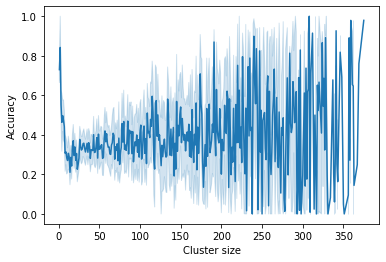

In [13]:
sns.lineplot(data=d2, x="cluster_size", y="acc")
plt.ylabel('Accuracy',fontsize=10)
plt.xlabel('Cluster size',fontsize=10)

Text(0.5, 0, 'Cluster size')

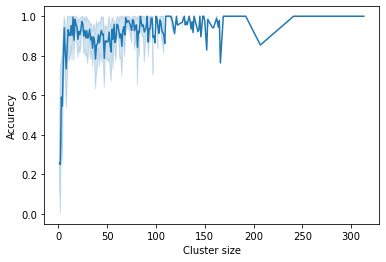

In [14]:
sns.lineplot(data=result_df[result_df['state']=='G'], x="cluster_size", y="acc")
plt.ylabel('Accuracy',fontsize=10)
plt.xlabel('Cluster size',fontsize=10)

In [15]:
item = 'external_size'

In [16]:
cats, bins = pd.qcut(result_df[item], 8, retbins=True, duplicates='drop',precision=2)
cat_dict = {cat: i for i, cat in enumerate(cats.unique())}
result_df[f"size_bins"] = cats
result_df

,sim,cluster_id,state,cluster_size,acc,org_cluster,external_size,size_bins
0,1004.0,c1,G,19,1.000000,NaN,10,"(6.0, 12.0]"
1,1004.0,c3,D,248,0.503817,NaN,131,"(72.5, 197.0]"
2,1004.0,c2,F,94,1.000000,NaN,54,"(44.0, 72.5]"
3,1006.0,c5,D,58,0.000000,NaN,34,"(30.0, 44.0]"
4,1006.0,c1,G,13,0.000000,NaN,7,"(6.0, 12.0]"
...,...,...,...,...,...,...,...,...
13208,19984.0,c1,B,38,0.250000,NaN,20,"(17.0, 22.0]"
13209,19984.0,c2,D,57,0.750000,NaN,32,"(30.0, 44.0]"
13210,19990.0,c3,C,9,0.000000,NaN,5,"(0.99, 6.0]"
13211,19990.0,c2,B,11,0.571429,NaN,7,"(6.0, 12.0]"


In [16]:
num_clu = []
for bi in a:
    print(bi)
    print(len(result_df[result_df['size_bins']==bi]))
    num_clu.append(len(result_df[result_df['size_bins']==bi]))

NameError: name 'a' is not defined

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (8,) and arg 1 with shape (0,).

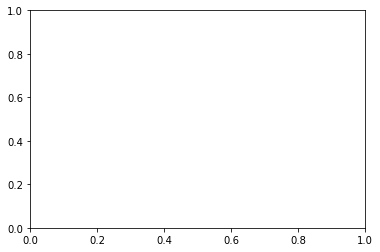

In [25]:
plt.bar([i for i in range(8)], num_clu,width = 0.4)
plt.xlabel("Bin")
plt.ylabel("Number of clusters")

In [17]:
cats.unique()

[(6.0, 12.0], (72.5, 197.0], (44.0, 72.5], (30.0, 44.0], (12.0, 17.0], (17.0, 22.0], (22.0, 30.0], (0.99, 6.0]]
Categories (8, interval[float64, right]): [(0.99, 6.0] < (6.0, 12.0] < (12.0, 17.0] < (17.0, 22.0] < (22.0, 30.0] < (30.0, 44.0] < (44.0, 72.5] < (72.5, 197.0]]

In [18]:
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, f1_score, balanced_accuracy_score, brier_score_loss, log_loss, precision_score, recall_score
import torch.nn.functional as F
import torch
torch.set_default_tensor_type(torch.DoubleTensor)
def cal_auc(subtree_df, subleaf_df, subres_df, cats, metric):
    bin_list = []
    met = []
    bacc_list = []
    for interval in cats.unique():
        bin_list.append(interval)
        subsubres_df = subres_df[subres_df['size_bins'] == interval]
        subsubres_df = subsubres_df.reset_index(drop=True)
        for i in range(len(subsubres_df)):
            tree = subsubres_df['sim'].iloc[i]
            clu = subsubres_df['cluster_id'].iloc[i]
            onetree = subleaf_df[subleaf_df['sim'] == tree]
            if i == 0:
                y_true = onetree[onetree['Cluster ID'] == clu]['label'].values
                y_pred = onetree[onetree['Cluster ID'] == clu]['pred_label'].values
            else:
                y_true = np.concatenate((y_true, onetree[onetree['Cluster ID'] == clu]['label'].values))
                y_pred = np.concatenate((y_pred, onetree[onetree['Cluster ID'] == clu]['pred_label'].values))
        #acc_list.append(accuracy_score(y_true, y_pred))
        if metric == 'acc':
            bacc_list.append(balanced_accuracy_score(y_true, y_pred))
        elif metric == 'f1':
            bacc_list.append(f1_score(y_true, y_pred, average='macro'))
        elif metric == 'pr':
            bacc_list.append(precision_score(y_true, y_pred, average = 'macro'))
        met.append(metric)
        #y_true = subsub_df['label'].values
        #y_pred = subsub_df[['pred_score_0','pred_score_1','pred_score_2']].values
        #acc = F.cross_entropy(torch.from_numpy(y_pred), torch.from_numpy(y_true), weight=torch.tensor(label_weights), size_average=None, reduce=None, reduction='mean')
        #acc_list.append(acc.cpu().detach().numpy().tolist())
    return bin_list,bacc_list,met

In [19]:
bin_list

NameError: name 'bin_list' is not defined

In [20]:
tree_ids.shape

(3152,)

In [21]:
group_df = pd.DataFrame(columns=['size_bins','balanced_acc','metric'])
num_trees = 500
all_bins = []
metric = []
all_bacc = []
#for m in ['acc','pr','f1']:
for m in ['acc']:
    for i in range(200):
        np.random.shuffle(tree_ids)
        subtree_df = df[df['sim'].isin(tree_ids[0:num_trees])]
        subtree_df = subtree_df.reset_index(drop=True)
        subleaf_df = leaf[leaf['sim'].isin(tree_ids[0:num_trees])]
        subleaf_df = subleaf_df.reset_index(drop=True)
        subres_df = result_df[result_df['sim'].isin(tree_ids[0:num_trees])]
        subres_df = subres_df.reset_index(drop=True)
        bins,bacc,met = cal_auc(subtree_df, subleaf_df, subres_df, cats, m)
        all_bins = all_bins+bins
        metric += met
        all_bacc = all_bacc+bacc
group_df['size_bins'] = all_bins
group_df['balanced_acc'] = all_bacc
group_df['metric'] = metric
group_df

,size_bins,balanced_acc,metric
0,"(6.0, 12.0]",0.573513,acc
1,"(72.5, 197.0]",0.776899,acc
2,"(44.0, 72.5]",0.733879,acc
3,"(30.0, 44.0]",0.715517,acc
4,"(12.0, 17.0]",0.604452,acc
...,...,...,...
1595,"(30.0, 44.0]",0.730579,acc
1596,"(12.0, 17.0]",0.599957,acc
1597,"(17.0, 22.0]",0.632333,acc
1598,"(22.0, 30.0]",0.694807,acc


In [22]:
group_df

,size_bins,balanced_acc,metric
0,"(6.0, 12.0]",0.573513,acc
1,"(72.5, 197.0]",0.776899,acc
2,"(44.0, 72.5]",0.733879,acc
3,"(30.0, 44.0]",0.715517,acc
4,"(12.0, 17.0]",0.604452,acc
...,...,...,...
1595,"(30.0, 44.0]",0.730579,acc
1596,"(12.0, 17.0]",0.599957,acc
1597,"(17.0, 22.0]",0.632333,acc
1598,"(22.0, 30.0]",0.694807,acc


Text(0.5, 0, 'Cluster size')

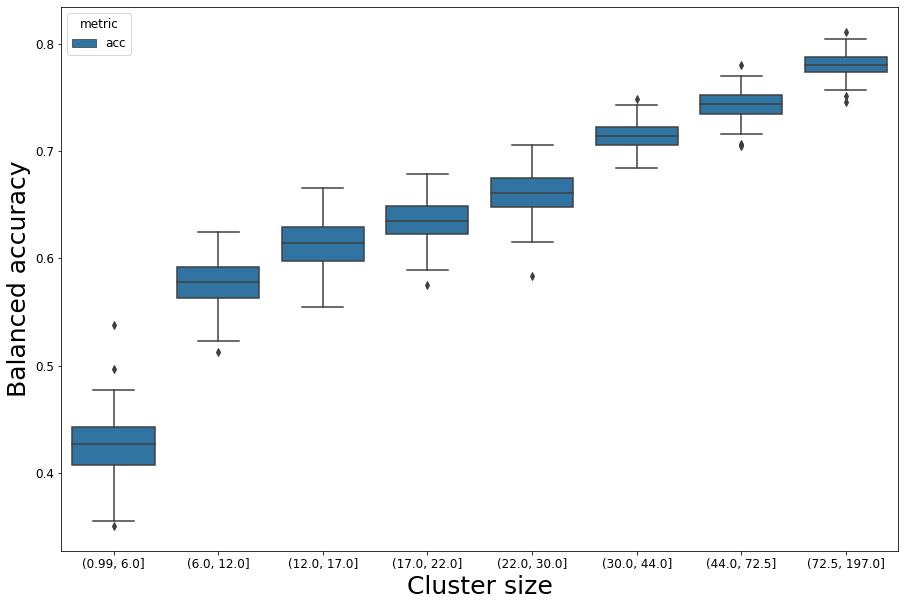

In [23]:
fig2 = plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 12})
a = list(cats.unique())
a.sort()
sns.boxplot(x='size_bins', y='balanced_acc',hue='metric', data=group_df,order=a)
plt.ylabel('Balanced accuracy',fontsize=25)
plt.xlabel('Cluster size',fontsize=25)

[Text(0, 0, '(0.99, 6.0]'),
 Text(1, 0, '(6.0, 12.0]'),
 Text(2, 0, '(12.0, 17.0]'),
 Text(3, 0, '(17.0, 22.0]'),
 Text(4, 0, '(22.0, 30.0]'),
 Text(5, 0, '(30.0, 44.0]'),
 Text(6, 0, '(44.0, 72.5]'),
 Text(7, 0, '(72.5, 197.0]')]

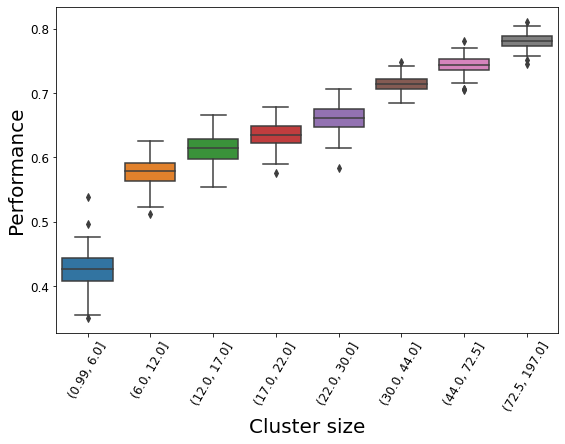

In [24]:
fig2 = plt.figure(figsize=(9, 6))
plt.rcParams.update({'font.size': 12})
a = list(cats.unique())
a.sort()
ax = sns.boxplot(x='size_bins', y='balanced_acc', data=group_df,order=a)
plt.ylabel('Performance',fontsize=20)
plt.xlabel('Cluster size',fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)

In [25]:
perform_all = group_df

In [26]:
nobg_leaf = leaf[leaf['Cluster ID']!='Background']
nobg_leaf

,sim,cluster_id,state,node,label,pred_label,pred_score_0,pred_score_1,pred_score_2,Cluster ID,State
105,1004.0,1.0,6.0,108.0,1,1,-0.860327,1.390367,-2.531936,c1,G
136,1004.0,3.0,3.0,139.0,0,0,0.490389,-1.074976,-1.797352,c3,D
137,1004.0,3.0,3.0,140.0,0,1,-0.823697,1.059744,-1.005755,c3,D
153,1004.0,2.0,5.0,156.0,2,2,-2.318816,-4.691636,2.535880,c2,F
231,1004.0,1.0,6.0,244.0,1,1,-0.699860,1.130470,-2.475338,c1,G
...,...,...,...,...,...,...,...,...,...,...,...
10263830,19990.0,3.0,2.0,1651.0,0,1,0.091527,0.677838,-3.277902,c3,C
10263831,19990.0,3.0,2.0,1652.0,0,1,0.185617,0.569087,-3.635821,c3,C
10264046,19990.0,1.0,3.0,1867.0,2,2,-0.373779,-2.610239,1.463069,c1,D
10265259,19990.0,2.0,1.0,3080.0,0,0,0.244551,0.046643,-1.614293,c2,B


In [27]:
num_trees = 500
ave_acc = []
for i in range(200):
    np.random.shuffle(tree_ids)
    sub_df = nobg_leaf[nobg_leaf['sim'].isin(tree_ids[0:num_trees])]
    sub_df = sub_df.reset_index(drop=True)
    y_true = sub_df['label'].values
    y_pred = sub_df['pred_label'].values
    ave_acc.append(balanced_accuracy_score(y_true, y_pred))

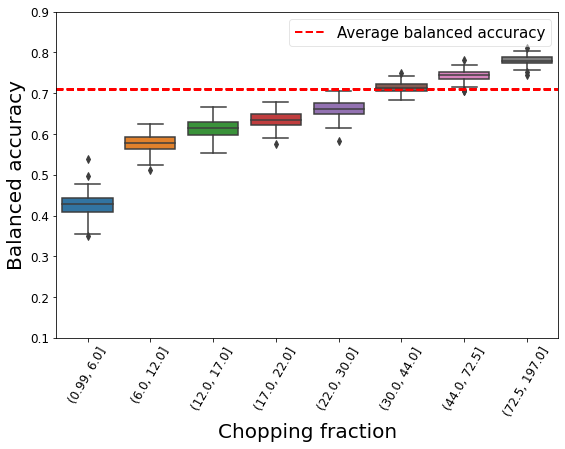

In [28]:
import scipy.stats
import matplotlib.pyplot as plt
y_mean = np.mean(ave_acc)
low_CI_bound,high_CI_bound = scipy.stats.t.interval(0.95,200-1,loc=y_mean,
                                                   scale=scipy.stats.sem(ave_acc))
fig2 = plt.figure(figsize=(9, 6))
plt.rcParams.update({'font.size': 12})
a = list(cats.unique())
a.sort()
ax = sns.boxplot(x='size_bins', y='balanced_acc', data=group_df,order=a)
plt.ylabel('Balanced accuracy',fontsize=20)
p1 = plt.axhline(linewidth=2, color='r', ls='dashed', y=y_mean)
p2 = plt.axhline(linewidth=2, color='r', ls='dashed', y=low_CI_bound)
p3 = plt.axhline(linewidth=2, color='r', ls='dashed', y=high_CI_bound)
plt.xlabel('Chopping fraction',fontsize=20)
plt.legend([p1],['Average balanced accuracy'],loc="upper right",fontsize=15,framealpha=0.5)
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
ax.set(ylim=(0.1, 0.9))
all_low = low_CI_bound
all_high = high_CI_bound
all_mean = y_mean

In [29]:
low_CI_bound,high_CI_bound

(0.7085539817330766, 0.7104607382571391)

In [36]:
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, f1_score, balanced_accuracy_score, brier_score_loss, log_loss, precision_score, recall_score
import torch.nn.functional as F
import torch
torch.set_default_tensor_type(torch.DoubleTensor)
def cal_auc(subtree_df, subleaf_df, subres_df, cats, metric):
    bin_list = []
    met = []
    bacc_list = []
    for interval in cats.unique():
        bin_list.append(interval)
        subsubres_df = subres_df[subres_df['size_bins'] == interval]
        subsubres_df = subsubres_df.reset_index(drop=True)
        for i in range(len(subsubres_df)):
            tree = subsubres_df['sim'].iloc[i]
            clu = subsubres_df['cluster_id'].iloc[i]
            onetree = subleaf_df[subleaf_df['sim'] == tree]
            if i == 0:
                y_true = onetree[onetree['Cluster ID'] == clu]['label'].values
                y_pred = onetree[onetree['Cluster ID'] == clu]['pred_label'].values
            else:
                y_true = np.concatenate((y_true, onetree[onetree['Cluster ID'] == clu]['label'].values))
                y_pred = np.concatenate((y_pred, onetree[onetree['Cluster ID'] == clu]['pred_label'].values))
        #acc_list.append(accuracy_score(y_true, y_pred))
        grow = np.where(y_true==1)
        y_true = y_true[grow[0]]
        y_pred = y_pred[grow[0]]
        mis = np.where(y_pred!=1)
        y_pred[mis[0]] = 0
        if metric == 'acc':
            bacc_list.append(accuracy_score(y_true, y_pred))
        elif metric == 'f1':
            bacc_list.append(f1_score(y_true, y_pred))
        elif metric == 'pr':
            bacc_list.append(precision_score(y_true, y_pred))
        met.append(metric)
        #y_true = subsub_df['label'].values
        #y_pred = subsub_df[['pred_score_0','pred_score_1','pred_score_2']].values
        #acc = F.cross_entropy(torch.from_numpy(y_pred), torch.from_numpy(y_true), weight=torch.tensor(label_weights), size_average=None, reduce=None, reduction='mean')
        #acc_list.append(acc.cpu().detach().numpy().tolist())
    return bin_list,bacc_list,met

In [37]:
group_df = pd.DataFrame(columns=['size_bins','balanced_acc','metric'])
num_trees = 500
all_bins = []
metric = []
all_bacc = []
for m in ['acc']:
    for i in range(200):
        np.random.shuffle(tree_ids)
        subtree_df = df[df['sim'].isin(tree_ids[0:num_trees])]
        subtree_df = subtree_df.reset_index(drop=True)
        subleaf_df = leaf[leaf['sim'].isin(tree_ids[0:num_trees])]
        subleaf_df = subleaf_df.reset_index(drop=True)
        subres_df = result_df[result_df['sim'].isin(tree_ids[0:num_trees])]
        subres_df = subres_df.reset_index(drop=True)
        bins,bacc,met = cal_auc(subtree_df, subleaf_df, subres_df, cats, m)
        all_bins = all_bins+bins
        metric += met
        all_bacc = all_bacc+bacc
group_df['size_bins'] = all_bins
group_df['balanced_acc'] = all_bacc
group_df['metric'] = metric
group_df

,size_bins,balanced_acc,metric
0,"(6.0, 12.0]",0.872675,acc
1,"(72.5, 197.0]",0.985185,acc
2,"(44.0, 72.5]",0.965414,acc
3,"(30.0, 44.0]",0.940032,acc
4,"(12.0, 17.0]",0.830556,acc
...,...,...,...
1595,"(30.0, 44.0]",0.917006,acc
1596,"(12.0, 17.0]",0.810848,acc
1597,"(17.0, 22.0]",0.820261,acc
1598,"(22.0, 30.0]",0.911224,acc


[Text(0, 0, '(0.99, 6.0]'),
 Text(1, 0, '(6.0, 12.0]'),
 Text(2, 0, '(12.0, 17.0]'),
 Text(3, 0, '(17.0, 22.0]'),
 Text(4, 0, '(22.0, 30.0]'),
 Text(5, 0, '(30.0, 44.0]'),
 Text(6, 0, '(44.0, 72.5]'),
 Text(7, 0, '(72.5, 197.0]')]

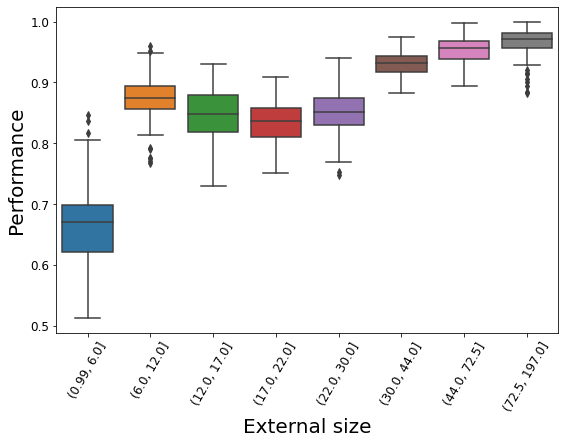

In [38]:
fig2 = plt.figure(figsize=(9, 6))
plt.rcParams.update({'font.size': 12})
a = list(cats.unique())
a.sort()
ax = sns.boxplot(x='size_bins', y='balanced_acc', data=group_df,order=a)
plt.ylabel('Performance',fontsize=20)
plt.xlabel('External size',fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)

In [39]:
num_trees = 500
ave_acc = []
for i in range(200):
    np.random.shuffle(tree_ids)
    sub_df = nobg_leaf[nobg_leaf['sim'].isin(tree_ids[0:num_trees])]
    sub_df = sub_df.reset_index(drop=True)
    y_true = sub_df['label'].values
    y_pred = sub_df['pred_label'].values
    grow = np.where(y_true==1)
    y_true = y_true[grow[0]]
    y_pred = y_pred[grow[0]]
    mis = np.where(y_pred!=1)
    y_pred[mis[0]] = 0
    ave_acc.append(accuracy_score(y_true, y_pred))

    #met.append(metric)
    #ave_acc.append(balanced_accuracy_score(y_true, y_pred))
    #ave_acc.append(f1_score(y_true, y_pred, average='macro'))
    #y_pred = sub_df[['pred_score_0','pred_score_1','pred_score_2']].values
    #acc = F.cross_entropy(torch.from_numpy(y_pred), torch.from_numpy(y_true), weight=torch.tensor(label_weights), size_average=None, reduce=None, reduction='mean')
    #ave_acc.append(acc.cpu().detach().numpy().tolist())

[Text(0, 0, '(0.99, 6.0]'),
 Text(1, 0, '(6.0, 12.0]'),
 Text(2, 0, '(12.0, 17.0]'),
 Text(3, 0, '(17.0, 22.0]'),
 Text(4, 0, '(22.0, 30.0]'),
 Text(5, 0, '(30.0, 44.0]'),
 Text(6, 0, '(44.0, 72.5]'),
 Text(7, 0, '(72.5, 197.0]')]

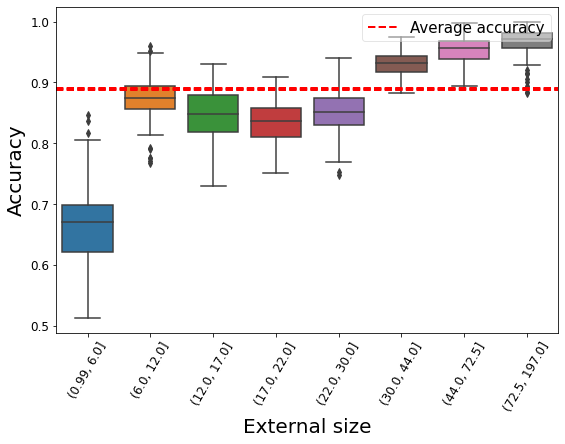

In [40]:
y_mean = np.mean(ave_acc)
low_CI_bound,high_CI_bound = scipy.stats.t.interval(0.95,200-1,loc=y_mean,
                                                   scale=scipy.stats.sem(ave_acc))
fig2 = plt.figure(figsize=(9, 6))
plt.rcParams.update({'font.size': 12})
a = list(cats.unique())
a.sort()
ax = sns.boxplot(x='size_bins', y='balanced_acc', data=group_df,order=a)
plt.ylabel('Accuracy',fontsize=20)
p1 = plt.axhline(linewidth=2, color='r', ls='dashed', y=y_mean)
p2 = plt.axhline(linewidth=2, color='r', ls='dashed', y=low_CI_bound)
p3 = plt.axhline(linewidth=2, color='r', ls='dashed', y=high_CI_bound)
plt.xlabel('External size',fontsize=20)
plt.legend([p1],['Average accuracy'],loc="upper right",fontsize=15,framealpha=0.5)
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)


In [35]:
growth = group_df
growth['label'] = 'growth'
growth_low = low_CI_bound
growth_high = high_CI_bound
growth_mean = y_mean
growth

,size_bins,balanced_acc,metric,label
0,"(6.0, 12.0]",0.643478,acc,growth
1,"(72.5, 197.0]",0.969809,acc,growth
2,"(44.0, 72.5]",0.960152,acc,growth
3,"(30.0, 44.0]",0.924334,acc,growth
4,"(12.0, 17.0]",0.736602,acc,growth
...,...,...,...,...
1595,"(30.0, 44.0]",0.906890,acc,growth
1596,"(12.0, 17.0]",0.684397,acc,growth
1597,"(17.0, 22.0]",0.840037,acc,growth
1598,"(22.0, 30.0]",0.894769,acc,growth


In [41]:
decay = group_df
decay['label'] = 'decay'
decay_low = low_CI_bound
decay_high = high_CI_bound
decay_mean = y_mean
decay


,size_bins,balanced_acc,metric,label
0,"(6.0, 12.0]",0.872675,acc,decay
1,"(72.5, 197.0]",0.985185,acc,decay
2,"(44.0, 72.5]",0.965414,acc,decay
3,"(30.0, 44.0]",0.940032,acc,decay
4,"(12.0, 17.0]",0.830556,acc,decay
...,...,...,...,...
1595,"(30.0, 44.0]",0.917006,acc,decay
1596,"(12.0, 17.0]",0.810848,acc,decay
1597,"(17.0, 22.0]",0.820261,acc,decay
1598,"(22.0, 30.0]",0.911224,acc,decay


In [52]:
static = group_df
static['label'] = 'static'
static_low = low_CI_bound
static_high = high_CI_bound
static_mean = y_mean
static

,size_bins,balanced_acc,metric,label
0,"(7.0, 12.0]",0.192214,acc,static
1,"(80.0, 197.0]",0.237193,acc,static
2,"(49.0, 80.0]",0.213971,acc,static
3,"(33.88, 49.0]",0.170704,acc,static
4,"(0.99, 7.0]",0.185185,acc,static
...,...,...,...,...
1595,"(33.88, 49.0]",0.141859,acc,static
1596,"(0.99, 7.0]",0.294931,acc,static
1597,"(12.0, 17.0]",0.074398,acc,static
1598,"(17.0, 24.0]",0.103211,acc,static


In [42]:
resp_df = pd.DataFrame(columns=['sim', 'cluster_id', 'state', 'cluster_size', 'acc','org_cluster']) 
tree_ids = df[df['sim']<=10000]['sim'].unique()

In [43]:
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, f1_score, balanced_accuracy_score, brier_score_loss, log_loss, precision_score, recall_score

x = []
x_leaf = []
y = []
sim = []
cid = []
s = []
#org_x = []
for i in tree_ids:
    if i > 10000:
        continue
    onetree = df[df['sim']==i]
    oneleaf = leaf[leaf['sim']==i]
    #orgonetree = node_df[node_df['sim']==i]
    for c in onetree['Cluster ID'].unique():
        #if c == 'Background':
        #    continue
        onecluleaf = oneleaf[oneleaf['Cluster ID']==c]
        oneclu = onetree[onetree['Cluster ID']==c]
        #orgoneclu = orgonetree[orgonetree['cluster_id']==c]
        y_true = onecluleaf['label'].values
        y_pred = onecluleaf['pred_label'].values
        x.append(len(oneclu))
        x_leaf.append(len(onecluleaf))
        #org_x.append(len(orgoneclu))
        y.append(accuracy_score(y_true,y_pred))
        sim.append(i)
        cid.append(c)
        s.append(oneclu['State'].unique()[0])
resp_df['cluster_size'] = x
resp_df['external_size'] = x_leaf
#result_df['org_cluster'] = org_x
resp_df['acc'] = y
resp_df['sim'] = sim
resp_df['cluster_id'] = cid
resp_df['state'] = s

In [44]:
resp_df

,sim,cluster_id,state,cluster_size,acc,org_cluster,external_size
0,1004.0,Background,A,3510,0.845686,NaN,1808
1,1004.0,c1,G,19,1.000000,NaN,10
2,1004.0,c3,D,248,0.503817,NaN,131
3,1004.0,c2,F,94,1.000000,NaN,54
4,1006.0,Background,A,3318,0.908187,NaN,1710
...,...,...,...,...,...,...,...
10738,9998.0,c3,D,166,0.000000,NaN,91
10739,9998.0,c2,B,140,0.837838,NaN,74
10740,9998.0,c6,E,28,0.000000,NaN,17
10741,9998.0,c5,F,6,0.000000,NaN,3


In [45]:
subtree_df

,sim,cluster_id,state,node,label,pred_label,pred_score_0,pred_score_1,pred_score_2,Cluster ID,State
0,1087.0,0.0,0.0,1.0,0,0,1.082019,-1.319033,-4.453589,Background,A
1,1087.0,0.0,0.0,2.0,0,0,1.329783,-1.419004,-4.463246,Background,A
2,1087.0,0.0,0.0,3.0,0,0,1.159742,-1.413739,-2.940445,Background,A
3,1087.0,0.0,0.0,4.0,0,0,1.044900,-0.958768,-4.616956,Background,A
4,1087.0,0.0,0.0,5.0,0,0,1.056034,-1.297168,-4.077815,Background,A
...,...,...,...,...,...,...,...,...,...,...,...
1638459,19968.0,0.0,0.0,258.0,3,0,0.847543,-0.947166,-1.550746,Background,A
1638460,19968.0,0.0,0.0,259.0,3,0,-0.389175,-0.873951,-1.920355,Background,A
1638461,19968.0,0.0,0.0,260.0,3,1,-0.889453,-0.255229,-1.882032,Background,A
1638462,19968.0,0.0,0.0,261.0,3,1,-1.189545,-0.528694,-2.402963,Background,A


In [46]:
group_df = pd.DataFrame(columns=['state','acc','metric'])
num_trees = 500
all_state = []
metric = []
all_bacc = []
#for m in ['acc','pr','f1']:
for m in ['acc']:
    for state in ['A','B','C','D','E','F','G']:
        substate = resp_df[resp_df['state']==state]
        substate = substate.reset_index(drop=True)
        tree_ids = substate['sim'].values
        for i in range(200):
            x = np.random.permutation(len(tree_ids))
            subtree_df = substate[substate['sim'].isin(tree_ids[x[0:num_trees]])]
            bacc = np.sum(subtree_df['acc'].values*subtree_df['external_size'].values)/np.sum(subtree_df['external_size'].values)
            all_state = all_state+[state]
            metric += [m]
            all_bacc = all_bacc+[bacc]
        
group_df['state'] = all_state
group_df['acc'] = all_bacc
group_df['metric'] = metric
group_df

,state,acc,metric
0,A,0.872593,acc
1,A,0.872300,acc
2,A,0.872515,acc
3,A,0.876032,acc
4,A,0.875342,acc
...,...,...,...
1395,G,0.910379,acc
1396,G,0.925558,acc
1397,G,0.927038,acc
1398,G,0.926000,acc


Text(0.5, 0, 'State')

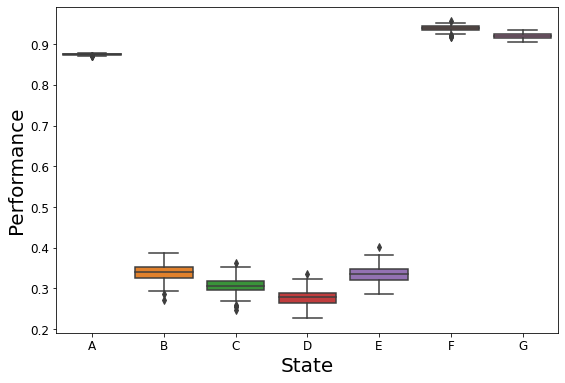

In [47]:
fig2 = plt.figure(figsize=(9, 6))
plt.rcParams.update({'font.size': 12})
a = list(cats.unique())
a.sort()
ax = sns.boxplot(x='state', y='acc', data=group_df,order=['A','B','C','D','E','F','G'])
plt.ylabel('Performance',fontsize=20)
plt.xlabel('State',fontsize=20)

In [48]:
resp_group = group_df
tree_ids = df[df['sim']<=10000]['sim'].unique()

In [49]:
num_trees = 500
ave_acc = []
for i in range(200):
    np.random.shuffle(tree_ids)
    sub_df = leaf[leaf['sim'].isin(tree_ids[0:num_trees])]
    sub_df = sub_df.reset_index(drop=True)
    y_true = sub_df['label'].values
    y_pred = sub_df['pred_label'].values
    ave_acc.append(balanced_accuracy_score(y_true, y_pred))

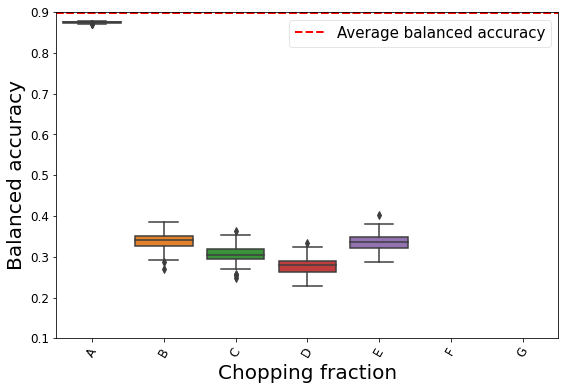

In [50]:
y_mean = np.mean(ave_acc)
low_CI_bound,high_CI_bound = scipy.stats.t.interval(0.95,200-1,loc=y_mean,
                                                   scale=scipy.stats.sem(ave_acc))
fig2 = plt.figure(figsize=(9, 6))
plt.rcParams.update({'font.size': 12})
a = list(cats.unique())
a.sort()
ax = sns.boxplot(x='state', y='acc', data=group_df,order=['A','B','C','D','E','F','G'])
plt.ylabel('Balanced accuracy',fontsize=20)
p1 = plt.axhline(linewidth=2, color='r', ls='dashed', y=y_mean)
p2 = plt.axhline(linewidth=2, color='r', ls='dashed', y=low_CI_bound)
p3 = plt.axhline(linewidth=2, color='r', ls='dashed', y=high_CI_bound)
plt.xlabel('Chopping fraction',fontsize=20)
plt.legend([p1],['Average balanced accuracy'],loc="upper right",fontsize=15,framealpha=0.5)
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
ax.set(ylim=(0.1, 0.9))
ari_low = low_CI_bound
ari_high = high_CI_bound
ari_mean = y_mean

In [51]:
tb_df = pd.DataFrame(columns=['sim', 'cluster_id', 'state', 'cluster_size', 'acc','org_cluster']) 
tree_ids = df[df['sim']>10000]['sim'].unique()

In [52]:
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, f1_score, balanced_accuracy_score, brier_score_loss, log_loss, precision_score, recall_score

x = []
x_leaf = []
y = []
sim = []
cid = []
s = []
#org_x = []
for i in tree_ids:
    if i <= 10000:
        continue
    onetree = df[df['sim']==i]
    oneleaf = leaf[leaf['sim']==i]
    #orgonetree = node_df[node_df['sim']==i]
    for c in onetree['Cluster ID'].unique():
        #if c == 'Background':
        #    continue
        onecluleaf = oneleaf[oneleaf['Cluster ID']==c]
        oneclu = onetree[onetree['Cluster ID']==c]
        #orgoneclu = orgonetree[orgonetree['cluster_id']==c]
        y_true = onecluleaf['label'].values
        y_pred = onecluleaf['pred_label'].values
        x.append(len(oneclu))
        x_leaf.append(len(onecluleaf))
        #org_x.append(len(orgoneclu))
        y.append(accuracy_score(y_true,y_pred))
        sim.append(i)
        cid.append(c)
        s.append(oneclu['State'].unique()[0])
tb_df['cluster_size'] = x
tb_df['external_size'] = x_leaf
#result_df['org_cluster'] = org_x
tb_df['acc'] = y
tb_df['sim'] = sim
tb_df['cluster_id'] = cid
tb_df['state'] = s

In [53]:
tb_df

,sim,cluster_id,state,cluster_size,acc,org_cluster,external_size
0,11009.0,Background,A,631,0.924925,NaN,333
1,11009.0,c2,C,60,0.818182,NaN,33
2,11009.0,c1,D,26,0.571429,NaN,14
3,11010.0,Background,A,505,0.931298,NaN,262
4,11010.0,c2,C,56,0.937500,NaN,32
...,...,...,...,...,...,...,...
5617,19984.0,c2,D,57,0.750000,NaN,32
5618,19990.0,Background,A,3003,0.887704,NaN,1594
5619,19990.0,c3,C,9,0.000000,NaN,5
5620,19990.0,c2,B,11,0.571429,NaN,7


In [54]:
group_df = pd.DataFrame(columns=['state','acc','metric'])
num_trees = 500
all_state = []
metric = []
all_bacc = []
#for m in ['acc','pr','f1']:
for m in ['acc']:
    for state in ['A','B','C','D','E']:
        substate = tb_df[tb_df['state']==state]
        substate = substate.reset_index(drop=True)
        tree_ids = substate['sim'].values
        for i in range(200):
            x = np.random.permutation(len(tree_ids))
            subtree_df = substate[substate['sim'].isin(tree_ids[x[0:num_trees]])]
            bacc = np.sum(subtree_df['acc'].values*subtree_df['external_size'].values)/np.sum(subtree_df['external_size'].values)
            all_state = all_state+[state]
            metric += [m]
            all_bacc = all_bacc+[bacc]
        
group_df['state'] = all_state
group_df['acc'] = all_bacc
group_df['metric'] = metric
group_df

,state,acc,metric
0,A,0.882991,acc
1,A,0.883336,acc
2,A,0.884481,acc
3,A,0.882606,acc
4,A,0.882869,acc
...,...,...,...
995,E,0.537354,acc
996,E,0.537354,acc
997,E,0.537354,acc
998,E,0.537354,acc


Text(0.5, 0, 'State')

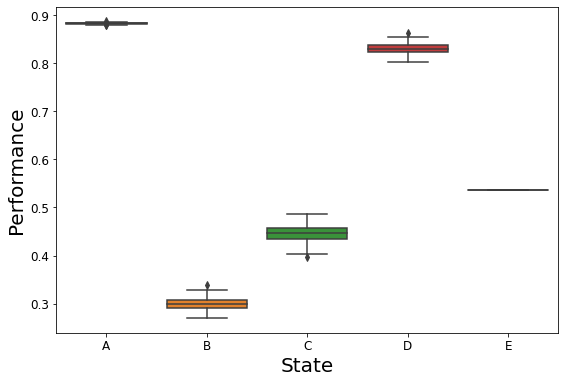

In [55]:
fig2 = plt.figure(figsize=(9, 6))
plt.rcParams.update({'font.size': 12})
a = list(cats.unique())
a.sort()
ax = sns.boxplot(x='state', y='acc', data=group_df,order=['A','B','C','D','E'])
plt.ylabel('Performance',fontsize=20)
plt.xlabel('State',fontsize=20)

In [56]:
tb_group = group_df
tree_ids = df[df['sim']>10000]['sim'].unique()

In [57]:
num_trees = 500
ave_acc = []
for i in range(200):
    np.random.shuffle(tree_ids)
    sub_df = leaf[leaf['sim'].isin(tree_ids[0:num_trees])]
    sub_df = sub_df.reset_index(drop=True)
    y_true = sub_df['label'].values
    y_pred = sub_df['pred_label'].values
    ave_acc.append(balanced_accuracy_score(y_true, y_pred))

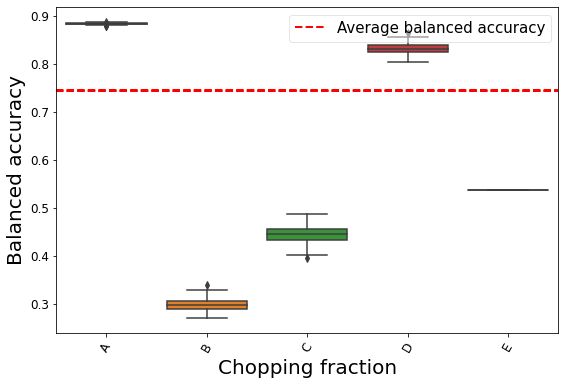

In [58]:
y_mean = np.mean(ave_acc)
low_CI_bound,high_CI_bound = scipy.stats.t.interval(0.95,200-1,loc=y_mean,
                                                   scale=scipy.stats.sem(ave_acc))
fig2 = plt.figure(figsize=(9, 6))
plt.rcParams.update({'font.size': 12})
a = list(cats.unique())
a.sort()
ax = sns.boxplot(x='state', y='acc', data=group_df,order=['A','B','C','D','E'])
plt.ylabel('Balanced accuracy',fontsize=20)
p1 = plt.axhline(linewidth=2, color='r', ls='dashed', y=y_mean)
p2 = plt.axhline(linewidth=2, color='r', ls='dashed', y=low_CI_bound)
p3 = plt.axhline(linewidth=2, color='r', ls='dashed', y=high_CI_bound)
plt.xlabel('Chopping fraction',fontsize=20)
plt.legend([p1],['Average balanced accuracy'],loc="upper right",fontsize=15,framealpha=0.5)
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
tb_low = low_CI_bound
tb_high = high_CI_bound
tb_mean = y_mean

In [59]:
tb_mean,tb_high,tb_low

(0.7437881539155414, 0.7453162692006271, 0.7422600386304558)

In [60]:
a

[Interval(0.99, 6.0, closed='right'),
 Interval(6.0, 12.0, closed='right'),
 Interval(12.0, 17.0, closed='right'),
 Interval(17.0, 22.0, closed='right'),
 Interval(22.0, 30.0, closed='right'),
 Interval(30.0, 44.0, closed='right'),
 Interval(44.0, 72.5, closed='right'),
 Interval(72.5, 197.0, closed='right')]

In [61]:
b = [
    pd.Interval(1,6,closed='both'),
    pd.Interval(6,12,closed='right'),
    pd.Interval(12,17,closed='right'),
    pd.Interval(17,22,closed='right'),
    pd.Interval(22,30,closed='right'),
    pd.Interval(30,44,closed='right'),
    pd.Interval(44,72,closed='right'),
    pd.Interval(72,197,closed='right'),
]

In [62]:
perform_all['new_size_bins'] = np.nan
decay['new_size_bins'] = np.nan
growth['new_size_bins'] = np.nan

In [63]:
for i in range(len(a)):
    perform_all['new_size_bins'].iloc[perform_all['size_bins']==a[i]] = b[i]
    decay['new_size_bins'].iloc[decay['size_bins']==a[i]] = b[i]
    growth['new_size_bins'].iloc[growth['size_bins']==a[i]] = b[i]

/home/chaoyue/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [64]:
perform_all

,size_bins,balanced_acc,metric,new_size_bins
0,"(6.0, 12.0]",0.573513,acc,"(6, 12]"
1,"(72.5, 197.0]",0.776899,acc,"(72, 197]"
2,"(44.0, 72.5]",0.733879,acc,"(44, 72]"
3,"(30.0, 44.0]",0.715517,acc,"(30, 44]"
4,"(12.0, 17.0]",0.604452,acc,"(12, 17]"
...,...,...,...,...
1595,"(30.0, 44.0]",0.730579,acc,"(30, 44]"
1596,"(12.0, 17.0]",0.599957,acc,"(12, 17]"
1597,"(17.0, 22.0]",0.632333,acc,"(17, 22]"
1598,"(22.0, 30.0]",0.694807,acc,"(22, 30]"


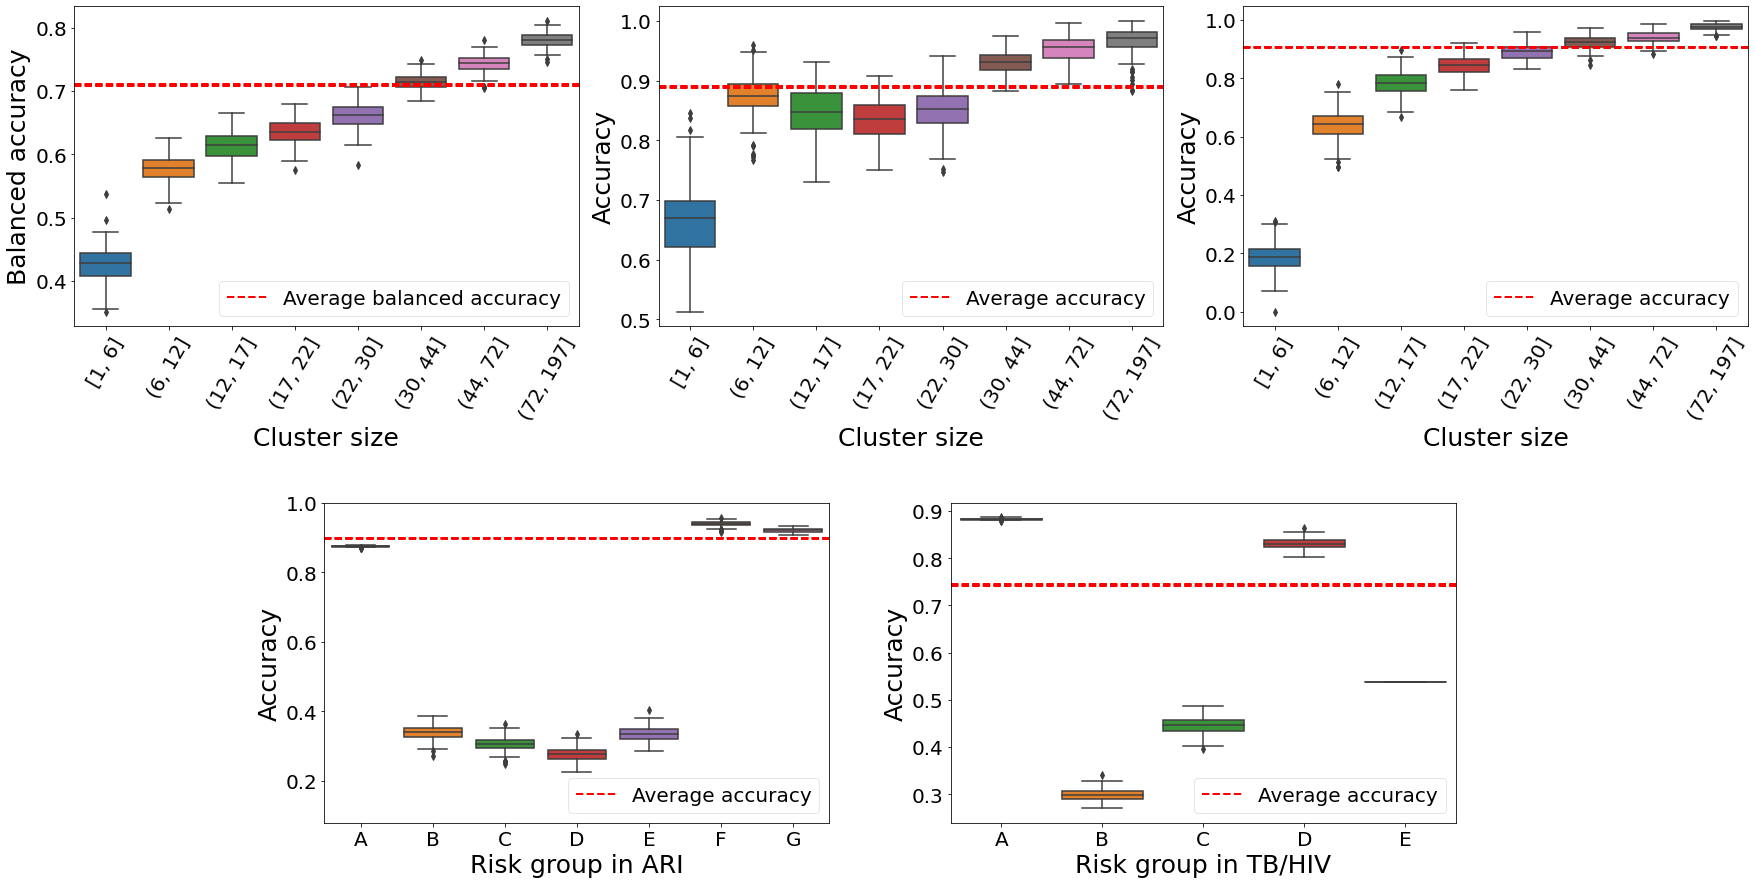

In [68]:
import scipy.stats
fig = plt.figure(figsize=(30,20))
grid = plt.GridSpec(25,41,wspace=10,hspace=10)
plt.rcParams.update({'font.size': 20})
    
plt.subplot(grid[1:9,0:13])
a = list(cats.unique())
a.sort()
ax = sns.boxplot(x='new_size_bins', y='balanced_acc', data=perform_all,order=b)
plt.ylabel('Balanced accuracy',fontsize=25)
plt.xlabel('Cluster size',fontsize=25)
p1 = plt.axhline(linewidth=2, color='r', ls='dashed', y=all_mean)
p2 = plt.axhline(linewidth=2, color='r', ls='dashed', y=all_low)
p3 = plt.axhline(linewidth=2, color='r', ls='dashed', y=all_high)
plt.xlabel('Cluster size',fontsize=25)
plt.legend([p1],['Average balanced accuracy'],loc="lower right",fontsize=20,framealpha=0.5)
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
#plt.title('a.',loc='left',fontsize=30)
#ax.set(ylim=(0.3, 0.9))
    
plt.subplot(grid[1:9,14:27])
ax = sns.boxplot(x='new_size_bins', y='balanced_acc', data=decay,order=b)
plt.ylabel('Accuracy',fontsize=25)
plt.xlabel('Cluster size',fontsize=25)
p1 = plt.axhline(linewidth=2, color='r', ls='dashed', y=decay_mean)
p2 = plt.axhline(linewidth=2, color='r', ls='dashed', y=decay_low)
p3 = plt.axhline(linewidth=2, color='r', ls='dashed', y=decay_high)
plt.legend([p1],['Average accuracy'],loc="lower right",fontsize=20,framealpha=0.5)
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
#ax.set(ylim=(0.4, 1.1))

plt.subplot(grid[1:9,28:41])
ax = sns.boxplot(x='new_size_bins', y='balanced_acc', data=growth,order=b)
plt.ylabel('Accuracy',fontsize=25)
plt.xlabel('Cluster size',fontsize=25)
p1 = plt.axhline(linewidth=2, color='r', ls='dashed', y=growth_mean)
p2 = plt.axhline(linewidth=2, color='r', ls='dashed', y=growth_low)
p3 = plt.axhline(linewidth=2, color='r', ls='dashed', y=growth_high)
plt.legend([p1],['Average accuracy'],loc="lower right",fontsize=20,framealpha=0.5)
ax.set_xticklabels(ax.get_xticklabels(),rotation=60) 

 
plt.subplot(grid[12:20,6:19])
ax = sns.boxplot(x='state', y='acc', data=resp_group,order=['A','B','C','D','E','F','G'])
plt.ylabel('Accuracy',fontsize=25)
plt.xlabel('Risk group in ARI',fontsize=25)
p1 = plt.axhline(linewidth=2, color='r', ls='dashed', y=ari_mean)
p2 = plt.axhline(linewidth=2, color='r', ls='dashed', y=ari_low)
p3 = plt.axhline(linewidth=2, color='r', ls='dashed', y=ari_high)
plt.legend([p1],['Average accuracy'],loc="lower right",fontsize=20,framealpha=0.5)
#plt.title('b.',loc='left',fontsize=30)
ax.set(ylim=(0.08, 1))

plt.subplot(grid[12:20,21:34])
ax = sns.boxplot(x='state', y='acc', data=tb_group,order=['A','B','C','D','E'])
plt.ylabel('Accuracy',fontsize=25)
plt.xlabel('Risk group in TB/HIV',fontsize=25)
p1 = plt.axhline(linewidth=2, color='r', ls='dashed', y=tb_mean)
p2 = plt.axhline(linewidth=2, color='r', ls='dashed', y=tb_low)
p3 = plt.axhline(linewidth=2, color='r', ls='dashed', y=tb_high)
plt.legend([p1],['Average accuracy'],loc="lower right",fontsize=20,framealpha=0.5)

plt.show()
fig.savefig('mis_aly.svg',dpi=1200,format='svg',bbox_inches='tight',pad_inches=0.0)

In [164]:
perform_all.to_csv('perform_all.csv')

In [165]:
growth.to_csv('growth.csv')

In [166]:
decay.to_csv('decay.csv')

In [167]:
resp_group.to_csv('resp_group.csv')

In [168]:
tb_group.to_csv('tb_group.csv')

In [53]:
all_label = pd.concat([static,pd.concat([decay,growth])])

[(0.0, 1.3)]

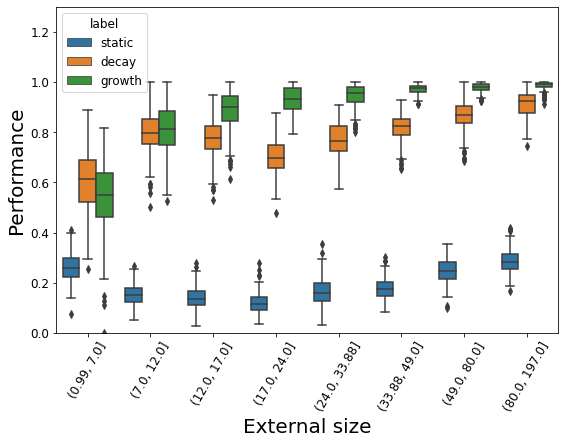

In [56]:
fig2 = plt.figure(figsize=(9, 6))
plt.rcParams.update({'font.size': 12})
a = list(cats.unique())
a.sort()
ax = sns.boxplot(x='size_bins', y='balanced_acc',hue='label', data=all_label,order=a)
plt.ylabel('Performance',fontsize=20)
plt.xlabel('External size',fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
ax.set(ylim=(0.0, 1.3))

[(0.0, 1.15)]

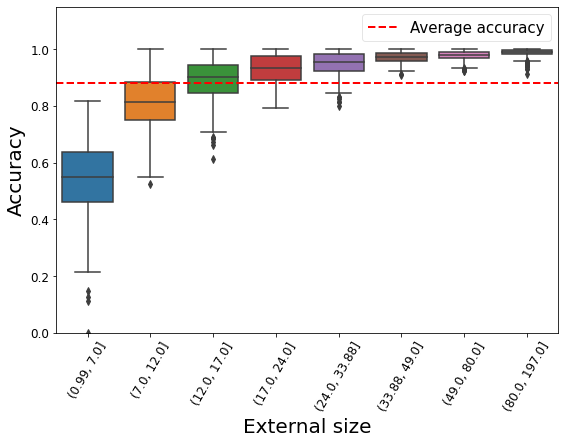

In [63]:
fig2 = plt.figure(figsize=(9, 6))
plt.rcParams.update({'font.size': 12})
a = list(cats.unique())
a.sort()
ax = sns.boxplot(x='size_bins', y='balanced_acc', data=growth,order=a)
plt.ylabel('Accuracy',fontsize=20)
p1 = plt.axhline(linewidth=2, color='r', ls='dashed', y=growth['balanced_acc'].mean())
plt.xlabel('External size',fontsize=20)
plt.legend([p1],['Average accuracy'],loc="upper right",fontsize=15,framealpha=0.5)
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
ax.set(ylim=(0.0, 1.15))

[(0.0, 1.15)]

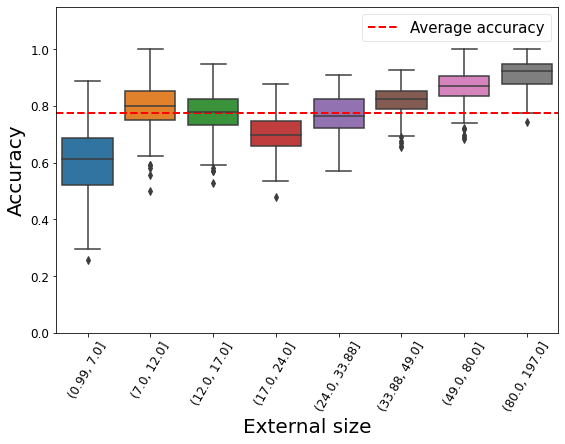

In [64]:
fig2 = plt.figure(figsize=(9, 6))
plt.rcParams.update({'font.size': 12})
a = list(cats.unique())
a.sort()
ax = sns.boxplot(x='size_bins', y='balanced_acc', data=decay,order=a)
plt.ylabel('Accuracy',fontsize=20)
p1 = plt.axhline(linewidth=2, color='r', ls='dashed', y=decay['balanced_acc'].mean())
plt.xlabel('External size',fontsize=20)
plt.legend([p1],['Average accuracy'],loc="upper right",fontsize=15,framealpha=0.5)
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
ax.set(ylim=(0.0, 1.15))

[(0.0, 0.5)]

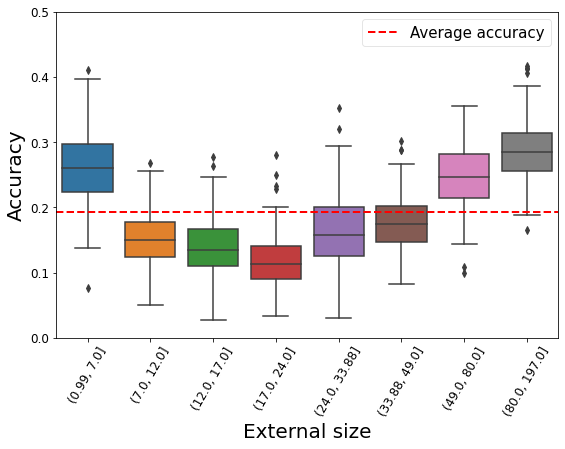

In [66]:
fig2 = plt.figure(figsize=(9, 6))
plt.rcParams.update({'font.size': 12})
a = list(cats.unique())
a.sort()
ax = sns.boxplot(x='size_bins', y='balanced_acc', data=static,order=a)
plt.ylabel('Accuracy',fontsize=20)
p1 = plt.axhline(linewidth=2, color='r', ls='dashed', y=static['balanced_acc'].mean())
plt.xlabel('External size',fontsize=20)
plt.legend([p1],['Average accuracy'],loc="upper right",fontsize=15,framealpha=0.5)
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
ax.set(ylim=(0.0, 0.5))

In [106]:
res_grow = result_df[result_df['state']=='F']
res_grow[res_grow['acc']>0.9]

,sim,cluster_id,state,cluster_size,acc,org_cluster,external_size,size_bins
2,1004.0,c2,F,94,1.000000,213,54,"(49.0, 80.0]"
6,1006.0,c2,F,14,1.000000,105,8,"(7.0, 12.0]"
12,1009.0,c2,F,147,1.000000,147,85,"(80.0, 197.0]"
17,1011.0,c2,F,52,0.965517,129,29,"(24.0, 33.88]"
28,1024.0,c3,F,56,1.000000,65,37,"(33.88, 49.0]"
...,...,...,...,...,...,...,...,...
8994,9963.0,c6,F,24,1.000000,232,14,"(12.0, 17.0]"
8999,9977.0,c4,F,33,1.000000,73,18,"(17.0, 24.0]"
9001,9979.0,c2,F,83,0.934783,167,46,"(33.88, 49.0]"
9009,9981.0,c1,F,95,1.000000,101,55,"(49.0, 80.0]"


In [107]:
res_grow

,sim,cluster_id,state,cluster_size,acc,org_cluster,external_size,size_bins
2,1004.0,c2,F,94,1.000000,213,54,"(49.0, 80.0]"
6,1006.0,c2,F,14,1.000000,105,8,"(7.0, 12.0]"
12,1009.0,c2,F,147,1.000000,147,85,"(80.0, 197.0]"
17,1011.0,c2,F,52,0.965517,129,29,"(24.0, 33.88]"
23,101.0,c5,F,1,0.000000,40,1,"(0.99, 7.0]"
...,...,...,...,...,...,...,...,...
9009,9981.0,c1,F,95,1.000000,101,55,"(49.0, 80.0]"
9013,9983.0,c2,F,1,0.000000,35,1,"(0.99, 7.0]"
9017,9991.0,c1,F,169,1.000000,266,113,"(80.0, 197.0]"
9020,9992.0,c4,F,34,0.900000,195,20,"(17.0, 24.0]"


In [20]:
random_seed = 123
np.random.seed(random_seed)
split_folder = f'/mnt/data2/chaoyue/data/ddf_resp_20230131/split_rs{random_seed}'
test_node_df = pd.read_csv(f'{split_folder}/test.csv')
test_edge_df = pd.read_csv(f'{split_folder}/test_edge.csv')

In [21]:
test_node_df

,index,sim,cluster_id,state,dynamic,node,dynamic_cat
0,15638,1004,Background,A,static,7,0
1,15639,1004,Background,A,static,258,0
2,15640,1004,Background,A,static,1184,0
3,15641,1004,Background,A,static,826,0
4,15642,1004,Background,A,static,1666,0
...,...,...,...,...,...,...,...
6164499,33702496,9998,c6,E,static,3304,0
6164500,33702497,9998,c6,E,static,1150,0
6164501,33702498,9998,c6,E,static,1969,0
6164502,33702499,9998,c6,E,static,1970,0


In [22]:
test_edge_df

,sim,new_from,new_to,weight1_arsinh-norm,weight2_arsinh-norm
0,1004,1866,1867,-0.323070,-0.602498
1,1004,1867,1868,-1.625870,-1.095046
2,1004,1868,1869,-1.022152,-0.928265
3,1004,1869,1870,0.103273,-0.200724
4,1004,1870,1871,-0.089291,-0.402260
...,...,...,...,...,...
6162784,9998,3921,3922,-0.323070,-0.627705
6162785,9998,3922,108,-0.323070,-0.589188
6162786,9998,3922,3923,0.266847,-0.125765
6162787,9998,3923,357,0.534553,0.045834


In [23]:
test_node_df['sim'].unique()

array([1004, 1006, 1009, ..., 9991, 9992, 9998])

In [24]:
np.sum(result_df['sim'].unique()==test_node_df['sim'].unique())

1715

In [25]:
result_df

,sim,cluster_id,state,cluster_size,acc,org_cluster,external_size
0,1004.0,c1,G,72,0.897436,NaN,39
1,1004.0,c2,F,43,1.000000,NaN,24
2,1004.0,c3,D,2,0.000000,NaN,1
3,1006.0,c5,D,34,0.000000,NaN,20
4,1006.0,c1,G,15,0.500000,NaN,8
...,...,...,...,...,...,...,...
9023,9998.0,c3,D,134,0.000000,NaN,74
9024,9998.0,c2,B,131,0.695652,NaN,69
9025,9998.0,c4,C,280,0.000000,NaN,146
9026,9998.0,c6,E,26,0.000000,NaN,16


In [26]:
len(tree_ids)

1715

In [123]:
subedge = onecluedge[onecluedge['new_from']==3211]
subedge

,sim,new_from,new_to,weight1_arsinh-norm,weight2_arsinh-norm
6548,1006,3211,3212,0.927677,0.975059
6554,1006,3211,3214,-0.323070,-0.662494


In [145]:
from tqdm import tqdm
from collections import Counter
class cal_clade:
    def __init__(self, clu, edge, leaf):
        self.clu = clu
        self.edge = edge
        self.leaf = leaf
        self.max = 0
    
    def dfs(self, root):
        #print(root)
        if root in self.edge['new_from'].values:
            result = 0
            flag = True
            subedge = self.edge[self.edge['new_from']==root]
            for i in range(len(subedge)):
                a = self.dfs(subedge['new_to'].iloc[i])
                if a == 0:
                    flag = False
                result += a
            if flag:
                if result>self.max:
                    self.max = result
                return result
            else:
                return 0
        else:
            b = self.leaf[self.leaf['node']==root]
            if b['label'].values == b['pred_label'].values:
                if self.max == 0:
                    self.max = 1
                return 1
            else:
                return 0

In [176]:
clade = []
for i in range(len(result_df)):
    if result_df['acc'].iloc[i] == 0:
        clade.append(0)
    elif result_df['acc'].iloc[i] == 1:
        clade.append(result_df['external_size'].iloc[i])
    else:
        sim = result_df['sim'].iloc[i]
        onetreenode = test_node_df[test_node_df['sim']==sim]
        onetreeedge = test_edge_df[test_edge_df['sim']==sim]
        oneleaf = leaf[leaf['sim']==sim]
    
        c = result_df['cluster_id'].iloc[i]
        onecluleaf = oneleaf[oneleaf['Cluster ID']==c]
        oneclu = onetreenode[onetreenode['cluster_id']==c]
        onecluedge = onetreeedge[onetreeedge['new_to'].isin(oneclu['node'])]

        count_root = dict(Counter(onecluedge['new_from']))
        root_parent = [node for node,value in count_root.items() if value==1]
        root = onecluedge[onecluedge['new_from']==root_parent[0]]['new_to'].values[0]
        c1 = cal_clade(oneclu, onecluedge, onecluleaf)
        empty = c1.dfs(root)
        clade.append(c1.max)
result_df['max_clade'] = clade

In [177]:
result_df['frac'] = result_df['max_clade']/result_df['external_size']

In [178]:
result_df[result_df['state']=='F']

,sim,cluster_id,state,cluster_size,acc,org_cluster,external_size,max_clade,frac,size_bins
1,1004.0,c2,F,43,1.000000,NaN,24,24,1.000000,"(18.0, 24.0]"
6,1006.0,c2,F,60,1.000000,NaN,35,35,1.000000,"(33.0, 50.0]"
12,1009.0,c2,F,125,1.000000,NaN,73,73,1.000000,"(50.0, 80.0]"
16,1011.0,c2,F,127,1.000000,NaN,70,70,1.000000,"(50.0, 80.0]"
23,101.0,c5,F,3,0.000000,NaN,2,0,0.000000,"(0.99, 7.0]"
...,...,...,...,...,...,...,...,...,...,...
9008,9981.0,c1,F,67,1.000000,NaN,38,38,1.000000,"(33.0, 50.0]"
9012,9983.0,c2,F,25,0.875000,NaN,16,14,0.875000,"(12.0, 18.0]"
9017,9991.0,c1,F,28,1.000000,NaN,16,16,1.000000,"(12.0, 18.0]"
9019,9992.0,c4,F,48,0.928571,NaN,28,26,0.928571,"(24.0, 33.0]"


Text(0.5, 0, 'External size')

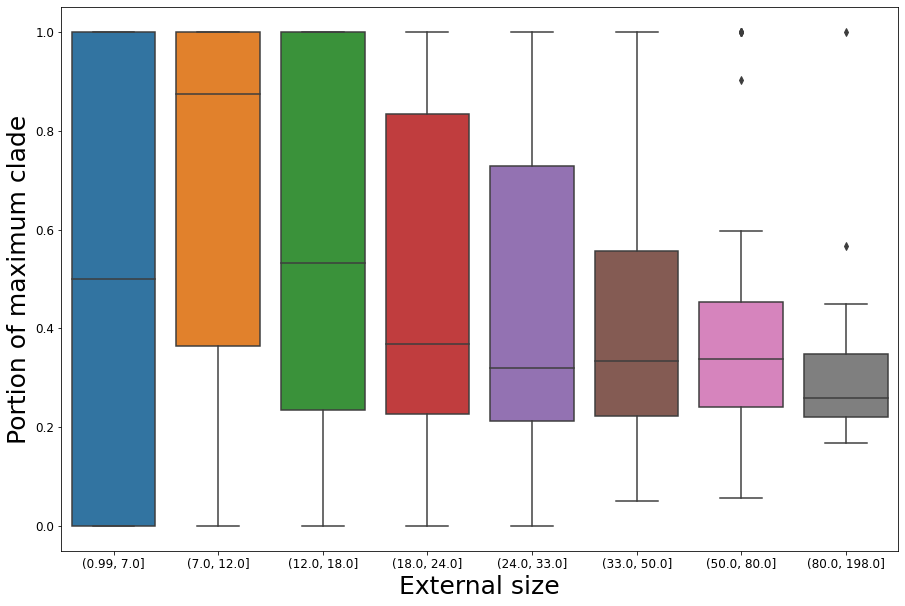

In [180]:
fig2 = plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 12})
a = list(cats.unique())
a.sort()
sns.boxplot(x='size_bins', y='frac', data=result_df[result_df['state']=='G'],order=a)
plt.ylabel('Portion of maximum clade',fontsize=25)
plt.xlabel('External size',fontsize=25)

In [182]:
decay = result_df[result_df['state']=='G']

In [184]:
decay

,sim,cluster_id,state,cluster_size,acc,org_cluster,external_size,max_clade,frac,size_bins
0,1004.0,c1,G,72,0.897436,NaN,39,9,0.230769,"(33.0, 50.0]"
4,1006.0,c1,G,15,0.500000,NaN,8,4,0.500000,"(7.0, 12.0]"
9,1009.0,c1,G,36,0.650000,NaN,20,2,0.100000,"(18.0, 24.0]"
13,1011.0,c4,G,20,1.000000,NaN,11,11,1.000000,"(7.0, 12.0]"
22,101.0,c1,G,1,0.000000,NaN,1,0,0.000000,"(0.99, 7.0]"
...,...,...,...,...,...,...,...,...,...,...
9004,9979.0,c3,G,49,0.884615,NaN,26,9,0.346154,"(24.0, 33.0]"
9007,9981.0,c3,G,34,0.368421,NaN,19,5,0.263158,"(18.0, 24.0]"
9011,9983.0,c3,G,19,1.000000,NaN,11,11,1.000000,"(7.0, 12.0]"
9020,9992.0,c2,G,1,1.000000,NaN,1,1,1.000000,"(0.99, 7.0]"


In [185]:
decay[decay['frac']>0.9]

,sim,cluster_id,state,cluster_size,acc,org_cluster,external_size,max_clade,frac,size_bins
13,1011.0,c4,G,20,1.0,NaN,11,11,1.0,"(7.0, 12.0]"
35,1031.0,c1,G,13,1.0,NaN,6,6,1.0,"(0.99, 7.0]"
49,1081.0,c1,G,20,1.0,NaN,11,11,1.0,"(7.0, 12.0]"
62,1094.0,c3,G,28,1.0,NaN,15,15,1.0,"(12.0, 18.0]"
73,10.0,c2,G,11,1.0,NaN,6,6,1.0,"(0.99, 7.0]"
...,...,...,...,...,...,...,...,...,...,...
8951,9877.0,c1,G,18,1.0,NaN,10,10,1.0,"(7.0, 12.0]"
8961,9896.0,c4,G,6,1.0,NaN,3,3,1.0,"(0.99, 7.0]"
8965,991.0,c1,G,29,1.0,NaN,16,16,1.0,"(12.0, 18.0]"
9011,9983.0,c3,G,19,1.0,NaN,11,11,1.0,"(7.0, 12.0]"


In [186]:
growth = result_df[result_df['state']=='F']

In [187]:
growth

,sim,cluster_id,state,cluster_size,acc,org_cluster,external_size,max_clade,frac,size_bins
1,1004.0,c2,F,43,1.000000,NaN,24,24,1.000000,"(18.0, 24.0]"
6,1006.0,c2,F,60,1.000000,NaN,35,35,1.000000,"(33.0, 50.0]"
12,1009.0,c2,F,125,1.000000,NaN,73,73,1.000000,"(50.0, 80.0]"
16,1011.0,c2,F,127,1.000000,NaN,70,70,1.000000,"(50.0, 80.0]"
23,101.0,c5,F,3,0.000000,NaN,2,0,0.000000,"(0.99, 7.0]"
...,...,...,...,...,...,...,...,...,...,...
9008,9981.0,c1,F,67,1.000000,NaN,38,38,1.000000,"(33.0, 50.0]"
9012,9983.0,c2,F,25,0.875000,NaN,16,14,0.875000,"(12.0, 18.0]"
9017,9991.0,c1,F,28,1.000000,NaN,16,16,1.000000,"(12.0, 18.0]"
9019,9992.0,c4,F,48,0.928571,NaN,28,26,0.928571,"(24.0, 33.0]"


In [189]:
growth[growth['frac']>0.5]

,sim,cluster_id,state,cluster_size,acc,org_cluster,external_size,max_clade,frac,size_bins
1,1004.0,c2,F,43,1.000000,NaN,24,24,1.000000,"(18.0, 24.0]"
6,1006.0,c2,F,60,1.000000,NaN,35,35,1.000000,"(33.0, 50.0]"
12,1009.0,c2,F,125,1.000000,NaN,73,73,1.000000,"(50.0, 80.0]"
16,1011.0,c2,F,127,1.000000,NaN,70,70,1.000000,"(50.0, 80.0]"
28,1024.0,c3,F,52,1.000000,NaN,35,35,1.000000,"(33.0, 50.0]"
...,...,...,...,...,...,...,...,...,...,...
9008,9981.0,c1,F,67,1.000000,NaN,38,38,1.000000,"(33.0, 50.0]"
9012,9983.0,c2,F,25,0.875000,NaN,16,14,0.875000,"(12.0, 18.0]"
9017,9991.0,c1,F,28,1.000000,NaN,16,16,1.000000,"(12.0, 18.0]"
9019,9992.0,c4,F,48,0.928571,NaN,28,26,0.928571,"(24.0, 33.0]"


In [203]:
4*10/(4+(10-4)*np.exp(-0.04*1))

4.096372641222037

In [208]:
18*20/(18+(20-18)*np.exp(0.4*3))

14.61025095206794